<a href="https://colab.research.google.com/github/galib96/sonar-prediction-rock-mine/blob/main/Prediction_of_mine_vs_rock_from_sonar_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Import Dependencies

In [142]:
# import packages

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import sklearn

from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, precision_score, recall_score, plot_confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, LeakyReLU, ReLU
from tensorflow.keras.regularizers import l1,l2
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.callbacks import EarlyStopping, LambdaCallback

Data Collection and exploration

Data has been collected from: https://archive.ics.uci.edu/ml/datasets/Connectionist+Bench+(Sonar,+Mines+vs.+Rocks)

In [4]:
# loading dataset as pandas dataframe
dataset = pd.read_csv("https://github.com/galib96/sonar-prediction-rock-mine/raw/main/Data/sonar-all-data.csv", header=None)

# check dataset shapes and preview
print(dataset.shape)
dataset.head()

(208, 61)


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60
0,0.0200,0.0371,0.0428,0.0207,0.0954,0.0986,0.1539,0.1601,0.3109,0.2111,0.1609,0.1582,0.2238,0.0645,0.0660,0.2273,0.3100,0.2999,0.5078,0.4797,0.5783,0.5071,0.4328,0.5550,0.6711,0.6415,0.7104,0.8080,0.6791,0.3857,0.1307,0.2604,0.5121,0.7547,0.8537,0.8507,0.6692,0.6097,0.4943,0.2744,0.0510,0.2834,0.2825,0.4256,0.2641,0.1386,0.1051,0.1343,0.0383,0.0324,0.0232,0.0027,0.0065,0.0159,0.0072,0.0167,0.0180,0.0084,0.0090,0.0032,R
1,0.0453,0.0523,0.0843,0.0689,0.1183,0.2583,0.2156,0.3481,0.3337,0.2872,0.4918,0.6552,0.6919,0.7797,0.7464,0.9444,1.0000,0.8874,0.8024,0.7818,0.5212,0.4052,0.3957,0.3914,0.3250,0.3200,0.3271,0.2767,0.4423,0.2028,0.3788,0.2947,0.1984,0.2341,0.1306,0.4182,0.3835,0.1057,0.1840,0.1970,0.1674,0.0583,0.1401,0.1628,0.0621,0.0203,0.0530,0.0742,0.0409,0.0061,0.0125,0.0084,0.0089,0.0048,0.0094,0.0191,0.0140,0.0049,0.0052,0.0044,R
2,0.0262,0.0582,0.1099,0.1083,0.0974,0.2280,0.2431,0.3771,0.5598,0.6194,0.6333,0.7060,0.5544,0.5320,0.6479,0.6931,0.6759,0.7551,0.8929,0.8619,0.7974,0.6737,0.4293,0.3648,0.5331,0.2413,0.5070,0.8533,0.6036,0.8514,0.8512,0.5045,0.1862,0.2709,0.4232,0.3043,0.6116,0.6756,0.5375,0.4719,0.4647,0.2587,0.2129,0.2222,0.2111,0.0176,0.1348,0.0744,0.0130,0.0106,0.0033,0.0232,0.0166,0.0095,0.0180,0.0244,0.0316,0.0164,0.0095,0.0078,R
3,0.0100,0.0171,0.0623,0.0205,0.0205,0.0368,0.1098,0.1276,0.0598,0.1264,0.0881,0.1992,0.0184,0.2261,0.1729,0.2131,0.0693,0.2281,0.4060,0.3973,0.2741,0.3690,0.5556,0.4846,0.3140,0.5334,0.5256,0.2520,0.2090,0.3559,0.6260,0.7340,0.6120,0.3497,0.3953,0.3012,0.5408,0.8814,0.9857,0.9167,0.6121,0.5006,0.3210,0.3202,0.4295,0.3654,0.2655,0.1576,0.0681,0.0294,0.0241,0.0121,0.0036,0.0150,0.0085,0.0073,0.0050,0.0044,0.0040,0.0117,R
4,0.0762,0.0666,0.0481,0.0394,0.0590,0.0649,0.1209,0.2467,0.3564,0.4459,0.4152,0.3952,0.4256,0.4135,0.4528,0.5326,0.7306,0.6193,0.2032,0.4636,0.4148,0.4292,0.5730,0.5399,0.3161,0.2285,0.6995,1.0000,0.7262,0.4724,0.5103,0.5459,0.2881,0.0981,0.1951,0.4181,0.4604,0.3217,0.2828,0.2430,0.1979,0.2444,0.1847,0.0841,0.0692,0.0528,0.0357,0.0085,0.0230,0.0046,0.0156,0.0031,0.0054,0.0105,0.0110,0.0015,0.0072,0.0048,0.0107,0.0094,R


In [6]:
# summary statistics of the dataset
dataset.describe()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59
count,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000
mean,0.029164,0.038437,0.043832,0.053892,0.075202,0.104570,0.121747,0.134799,0.178003,0.208259,0.236013,0.250221,0.273305,0.296568,0.320201,0.378487,0.415983,0.452318,0.504812,0.563047,0.609060,0.624275,0.646975,0.672654,0.675424,0.699866,0.702155,0.694024,0.642074,0.580928,0.504475,0.439040,0.417220,0.403233,0.392571,0.384848,0.363807,0.339657,0.325800,0.311207,0.289252,0.278293,0.246542,0.214075,0.197232,0.160631,0.122453,0.091424,0.051929,0.020424,0.016069,0.013420,0.010709,0.010941,0.009290,0.008222,0.007820,0.007949,0.007941,0.006507
std,0.022991,0.032960,0.038428,0.046528,0.055552,0.059105,0.061788,0.085152,0.118387,0.134416,0.132705,0.140072,0.140962,0.164474,0.205427,0.232650,0.263677,0.261529,0.257988,0.262653,0.257818,0.255883,0.250175,0.239116,0.244926,0.237228,0.245657,0.237189,0.240250,0.220749,0.213992,0.213237,0.206513,0.231242,0.259132,0.264121,0.239912,0.212973,0.199075,0.178662,0.171111,0.168728,0.138993,0.133291,0.151628,0.133938,0.086953,0.062417,0.035954,0.013665,0.012008,0.009634,0.007060,0.007301,0.007088,0.005736,0.005785,0.006470,0.006181,0.005031
min,0.001500,0.000600,0.001500,0.005800,0.006700,0.010200,0.003300,0.005500,0.007500,0.011300,0.028900,0.023600,0.018400,0.027300,0.003100,0.016200,0.034900,0.037500,0.049400,0.065600,0.051200,0.021900,0.056300,0.023900,0.024000,0.092100,0.048100,0.028400,0.014400,0.061300,0.048200,0.040400,0.047700,0.021200,0.022300,0.008000,0.035100,0.038300,0.037100,0.011700,0.036000,0.005600,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000800,0.000500,0.001000,0.000600,0.000400,0.000300,0.000300,0.000100,0.000600
25%,0.013350,0.016450,0.018950,0.024375,0.038050,0.067025,0.080900,0.080425,0.097025,0.111275,0.129250,0.133475,0.166125,0.175175,0.164625,0.196300,0.205850,0.242075,0.299075,0.350625,0.399725,0.406925,0.450225,0.540725,0.525800,0.544175,0.531900,0.534775,0.463700,0.411400,0.345550,0.281400,0.257875,0.217575,0.179375,0.154350,0.160100,0.174275,0.173975,0.186450,0.163100,0.158900,0.155200,0.126875,0.094475,0.068550,0.064250,0.045125,0.026350,0.011550,0.008425,0.007275,0.005075,0.005375,0.004150,0.004400,0.003700,0.003600,0.003675,0.003100
50%,0.022800,0.030800,0.034300,0.044050,0.062500,0.092150,0.106950,0.112100,0.152250,0.182400,0.224800,0.249050,0.263950,0.281100,0.281700,0.304700,0.308400,0.368300,0.434950,0.542500,0.617700,0.664900,0.699700,0.698500,0.721100,0.754500,0.745600,0.731900,0.680800,0.607150,0.490350,0.429600,0.391200,0.351050,0.312750,0.321150,0.306300,0.312700,0.283500,0.278050,0.259500,0.245100,0.222550,0.177700,0.148000,0.121350,0.101650,0.078100,0.044700,0.017900,0.013900,0.011400,0.009550,0.009300,0.007500,0.006850,0.005950,0.005800,0.006400,0.005300
75%,0.035550,0.047950,0.057950,0.064500,0.100275,0.134125,0.154000,0.169600,0.233425,0.268700,0.301650,0.331250,0.351250,0.386175,0.452925,0.535725,0.659425,0.679050,0.731400,0.809325,0.816975,0.831975,0.848575,0.872175,0.873725,0.893800,0.917100,0.900275,0.852125,0.735175,0.641950,0.580300,0.556125,0.596125,0.593350,0.556525,0.518900,0.440550,0.434900,0.424350,0.387525,0.384250,0.324525,0.271750,0.231550,0.200375,0.154425,0.120100,0.0685

M    111
R     97
Name: 60, dtype: int64


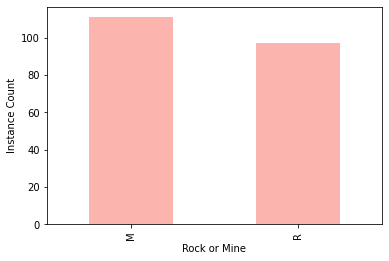

In [14]:
# check number of rock and mine instances
print(dataset[60].value_counts())

# visualizing the result
dataset[60].value_counts().plot(kind='bar', xlabel="Rock or Mine", ylabel = "Instance Count", colormap='Pastel1')

We can observe that class imbalance is almost absent which is good for us.

Now, we'll label R as 0 and Mine as 1 so that it can be used to train machine learning model.

In [15]:
dataset[60] = dataset[60].apply(lambda x: 0 if x == 'R' else 1)
dataset.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60
0,0.0200,0.0371,0.0428,0.0207,0.0954,0.0986,0.1539,0.1601,0.3109,0.2111,0.1609,0.1582,0.2238,0.0645,0.0660,0.2273,0.3100,0.2999,0.5078,0.4797,0.5783,0.5071,0.4328,0.5550,0.6711,0.6415,0.7104,0.8080,0.6791,0.3857,0.1307,0.2604,0.5121,0.7547,0.8537,0.8507,0.6692,0.6097,0.4943,0.2744,0.0510,0.2834,0.2825,0.4256,0.2641,0.1386,0.1051,0.1343,0.0383,0.0324,0.0232,0.0027,0.0065,0.0159,0.0072,0.0167,0.0180,0.0084,0.0090,0.0032,0
1,0.0453,0.0523,0.0843,0.0689,0.1183,0.2583,0.2156,0.3481,0.3337,0.2872,0.4918,0.6552,0.6919,0.7797,0.7464,0.9444,1.0000,0.8874,0.8024,0.7818,0.5212,0.4052,0.3957,0.3914,0.3250,0.3200,0.3271,0.2767,0.4423,0.2028,0.3788,0.2947,0.1984,0.2341,0.1306,0.4182,0.3835,0.1057,0.1840,0.1970,0.1674,0.0583,0.1401,0.1628,0.0621,0.0203,0.0530,0.0742,0.0409,0.0061,0.0125,0.0084,0.0089,0.0048,0.0094,0.0191,0.0140,0.0049,0.0052,0.0044,0
2,0.0262,0.0582,0.1099,0.1083,0.0974,0.2280,0.2431,0.3771,0.5598,0.6194,0.6333,0.7060,0.5544,0.5320,0.6479,0.6931,0.6759,0.7551,0.8929,0.8619,0.7974,0.6737,0.4293,0.3648,0.5331,0.2413,0.5070,0.8533,0.6036,0.8514,0.8512,0.5045,0.1862,0.2709,0.4232,0.3043,0.6116,0.6756,0.5375,0.4719,0.4647,0.2587,0.2129,0.2222,0.2111,0.0176,0.1348,0.0744,0.0130,0.0106,0.0033,0.0232,0.0166,0.0095,0.0180,0.0244,0.0316,0.0164,0.0095,0.0078,0
3,0.0100,0.0171,0.0623,0.0205,0.0205,0.0368,0.1098,0.1276,0.0598,0.1264,0.0881,0.1992,0.0184,0.2261,0.1729,0.2131,0.0693,0.2281,0.4060,0.3973,0.2741,0.3690,0.5556,0.4846,0.3140,0.5334,0.5256,0.2520,0.2090,0.3559,0.6260,0.7340,0.6120,0.3497,0.3953,0.3012,0.5408,0.8814,0.9857,0.9167,0.6121,0.5006,0.3210,0.3202,0.4295,0.3654,0.2655,0.1576,0.0681,0.0294,0.0241,0.0121,0.0036,0.0150,0.0085,0.0073,0.0050,0.0044,0.0040,0.0117,0
4,0.0762,0.0666,0.0481,0.0394,0.0590,0.0649,0.1209,0.2467,0.3564,0.4459,0.4152,0.3952,0.4256,0.4135,0.4528,0.5326,0.7306,0.6193,0.2032,0.4636,0.4148,0.4292,0.5730,0.5399,0.3161,0.2285,0.6995,1.0000,0.7262,0.4724,0.5103,0.5459,0.2881,0.0981,0.1951,0.4181,0.4604,0.3217,0.2828,0.2430,0.1979,0.2444,0.1847,0.0841,0.0692,0.0528,0.0357,0.0085,0.0230,0.0046,0.0156,0.0031,0.0054,0.0105,0.0110,0.0015,0.0072,0.0048,0.0107,0.0094,0


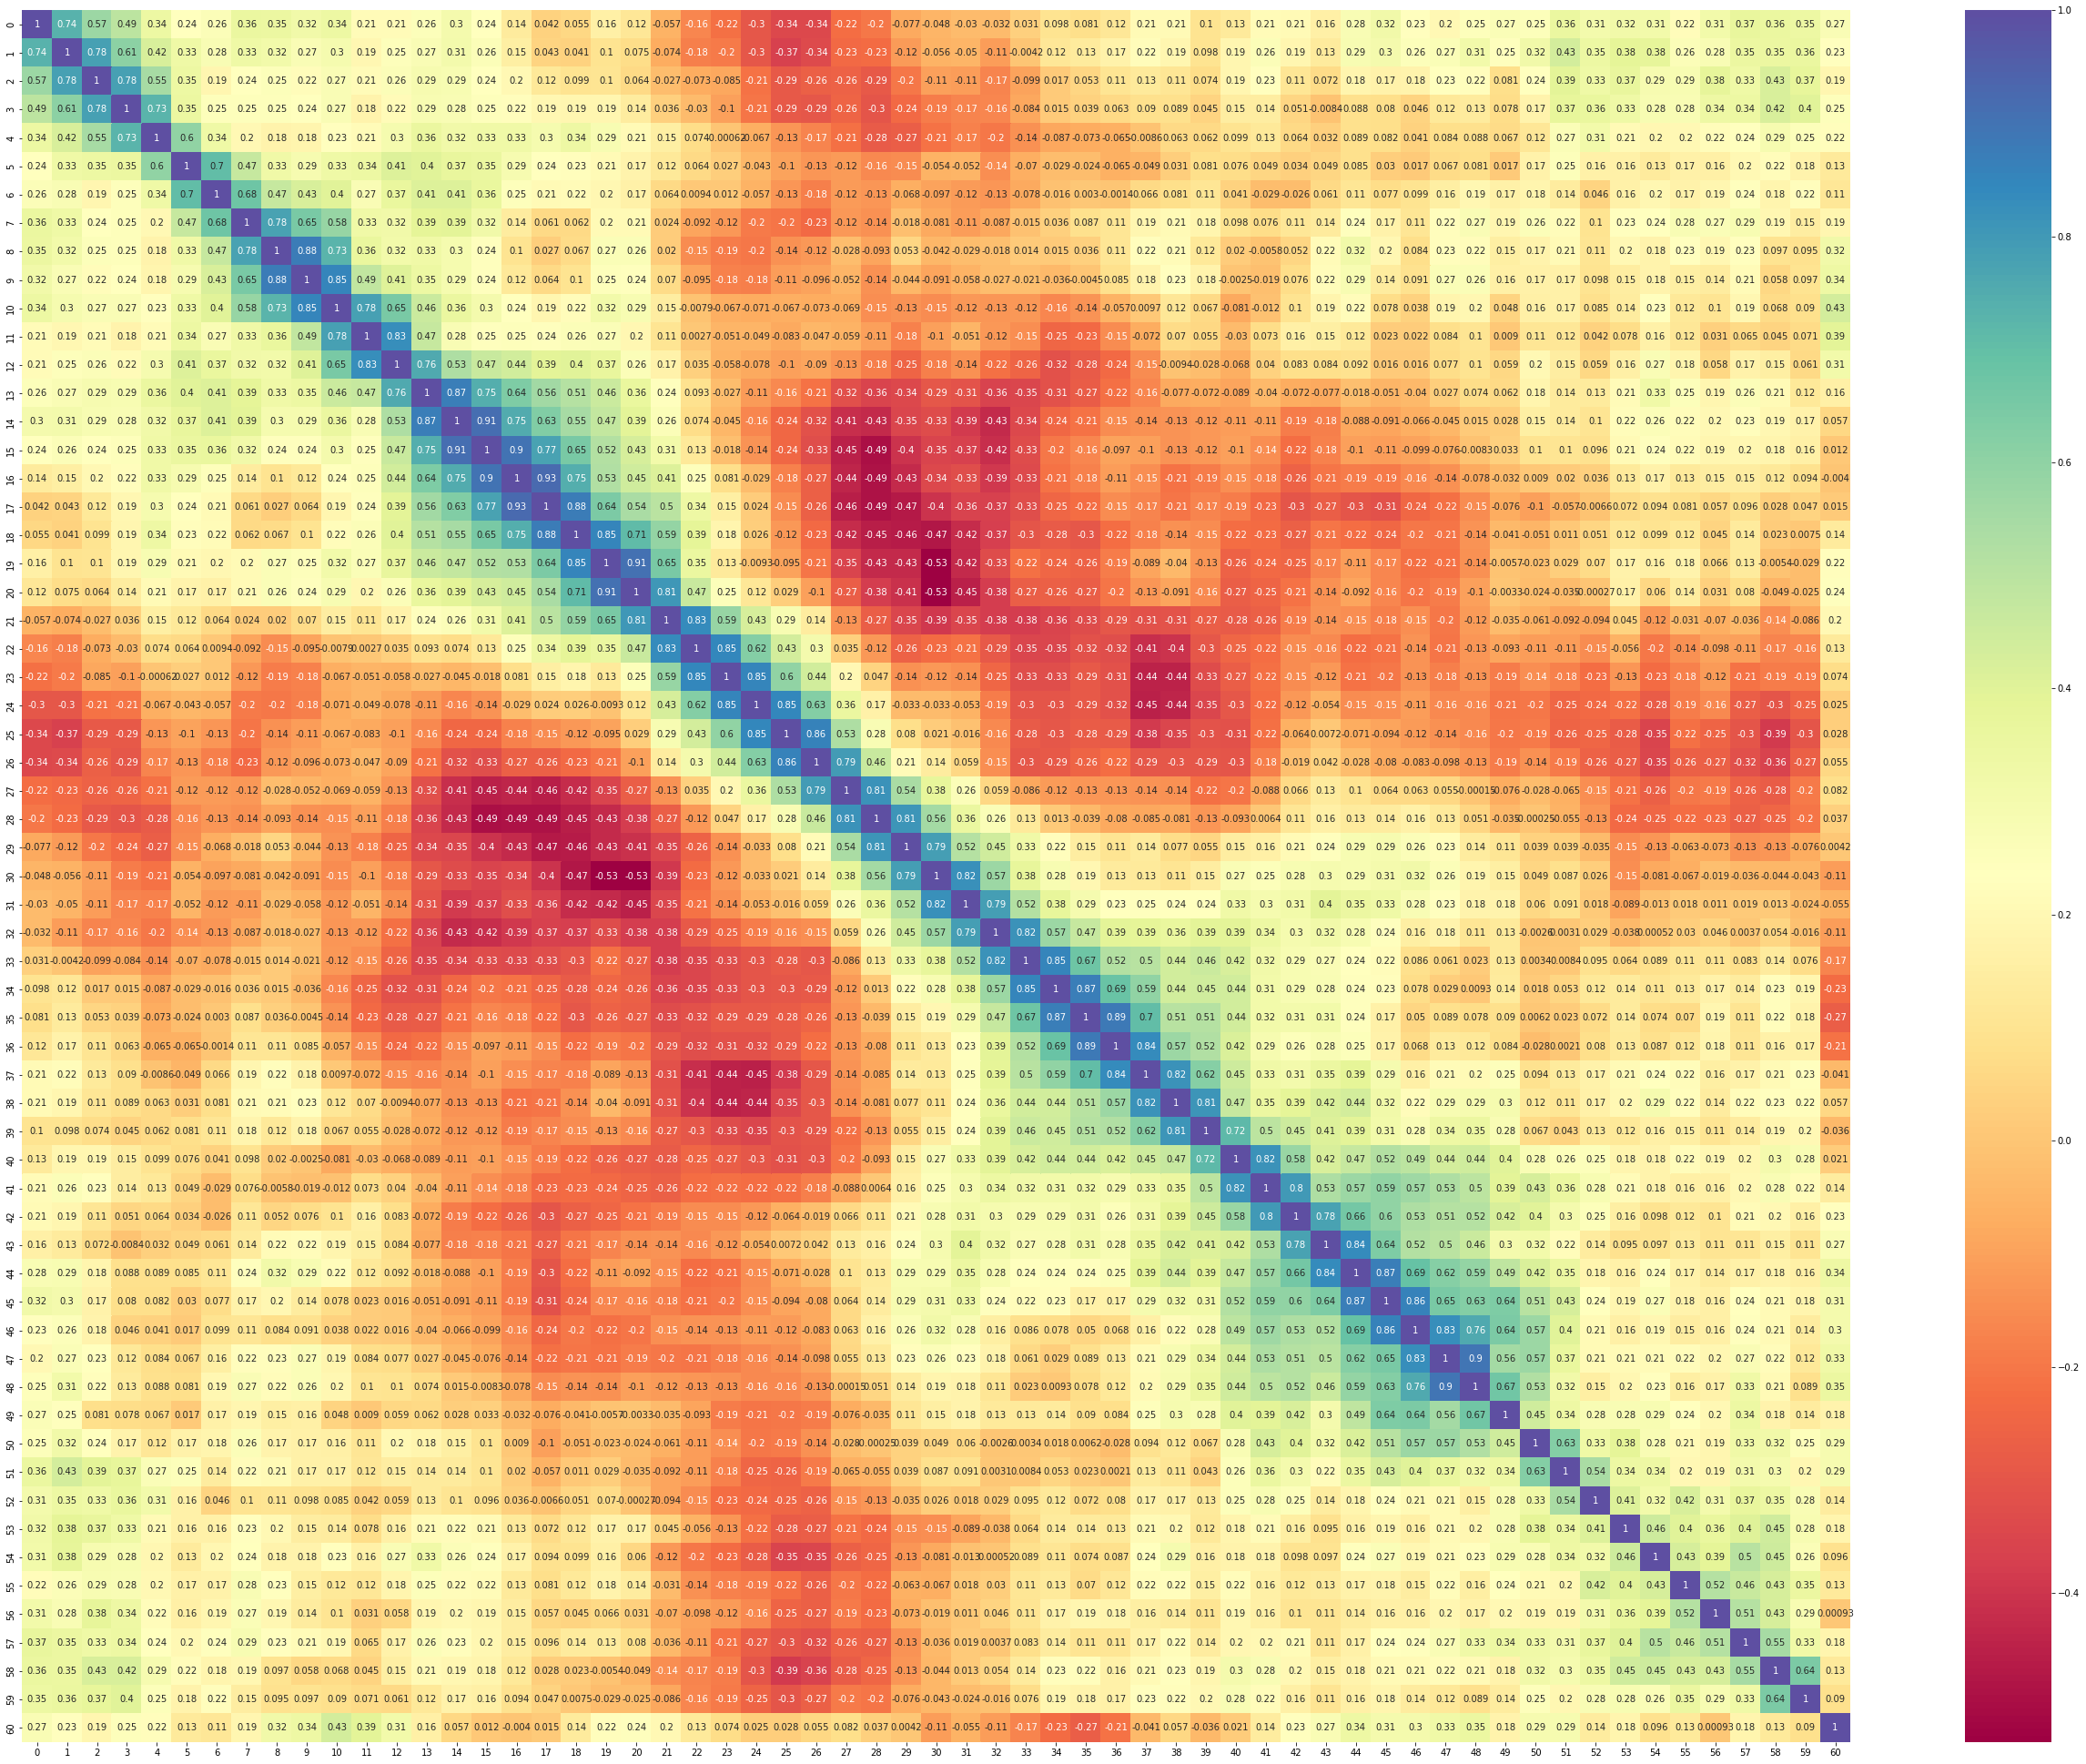

In [23]:
# correlation matrix using pearson method.
corr = dataset.corr(method='pearson')

# plotting the corelation matrix as heatmap
plt.figure(figsize = (45,35))
sns.heatmap(corr, cmap="Spectral", annot=True)

Data Preprocessing

The cfeatures with high internal correlation (greater than 0.9) will be removed.

In [92]:
# creating copy of dataset
df = dataset.copy()

# Create absolute correlation matrix
corr_matrix = df.corr().abs()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

# Find features with correlation greater than 0.95
to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]

# Drop features 
df.drop(to_drop, axis=1, inplace=True)

# Preview datset and dataset shape
print(df.shape)
df.head()

(208, 61)


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60
0,0.0200,0.0371,0.0428,0.0207,0.0954,0.0986,0.1539,0.1601,0.3109,0.2111,0.1609,0.1582,0.2238,0.0645,0.0660,0.2273,0.3100,0.2999,0.5078,0.4797,0.5783,0.5071,0.4328,0.5550,0.6711,0.6415,0.7104,0.8080,0.6791,0.3857,0.1307,0.2604,0.5121,0.7547,0.8537,0.8507,0.6692,0.6097,0.4943,0.2744,0.0510,0.2834,0.2825,0.4256,0.2641,0.1386,0.1051,0.1343,0.0383,0.0324,0.0232,0.0027,0.0065,0.0159,0.0072,0.0167,0.0180,0.0084,0.0090,0.0032,0
1,0.0453,0.0523,0.0843,0.0689,0.1183,0.2583,0.2156,0.3481,0.3337,0.2872,0.4918,0.6552,0.6919,0.7797,0.7464,0.9444,1.0000,0.8874,0.8024,0.7818,0.5212,0.4052,0.3957,0.3914,0.3250,0.3200,0.3271,0.2767,0.4423,0.2028,0.3788,0.2947,0.1984,0.2341,0.1306,0.4182,0.3835,0.1057,0.1840,0.1970,0.1674,0.0583,0.1401,0.1628,0.0621,0.0203,0.0530,0.0742,0.0409,0.0061,0.0125,0.0084,0.0089,0.0048,0.0094,0.0191,0.0140,0.0049,0.0052,0.0044,0
2,0.0262,0.0582,0.1099,0.1083,0.0974,0.2280,0.2431,0.3771,0.5598,0.6194,0.6333,0.7060,0.5544,0.5320,0.6479,0.6931,0.6759,0.7551,0.8929,0.8619,0.7974,0.6737,0.4293,0.3648,0.5331,0.2413,0.5070,0.8533,0.6036,0.8514,0.8512,0.5045,0.1862,0.2709,0.4232,0.3043,0.6116,0.6756,0.5375,0.4719,0.4647,0.2587,0.2129,0.2222,0.2111,0.0176,0.1348,0.0744,0.0130,0.0106,0.0033,0.0232,0.0166,0.0095,0.0180,0.0244,0.0316,0.0164,0.0095,0.0078,0
3,0.0100,0.0171,0.0623,0.0205,0.0205,0.0368,0.1098,0.1276,0.0598,0.1264,0.0881,0.1992,0.0184,0.2261,0.1729,0.2131,0.0693,0.2281,0.4060,0.3973,0.2741,0.3690,0.5556,0.4846,0.3140,0.5334,0.5256,0.2520,0.2090,0.3559,0.6260,0.7340,0.6120,0.3497,0.3953,0.3012,0.5408,0.8814,0.9857,0.9167,0.6121,0.5006,0.3210,0.3202,0.4295,0.3654,0.2655,0.1576,0.0681,0.0294,0.0241,0.0121,0.0036,0.0150,0.0085,0.0073,0.0050,0.0044,0.0040,0.0117,0
4,0.0762,0.0666,0.0481,0.0394,0.0590,0.0649,0.1209,0.2467,0.3564,0.4459,0.4152,0.3952,0.4256,0.4135,0.4528,0.5326,0.7306,0.6193,0.2032,0.4636,0.4148,0.4292,0.5730,0.5399,0.3161,0.2285,0.6995,1.0000,0.7262,0.4724,0.5103,0.5459,0.2881,0.0981,0.1951,0.4181,0.4604,0.3217,0.2828,0.2430,0.1979,0.2444,0.1847,0.0841,0.0692,0.0528,0.0357,0.0085,0.0230,0.0046,0.0156,0.0031,0.0054,0.0105,0.0110,0.0015,0.0072,0.0048,0.0107,0.0094,0


In [109]:
# separating features and class
X = df.drop(columns=60, axis = 1).values
y = df[60].values

# train test split of the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.15, random_state=42)

# check shape of the train and test set
print("X_train shape", X_train.shape)
print("y_train", y_train.shape)
print("X_test", X_test.shape)
print("y_test", y_test.shape)

X_train shape (176, 60)
y_train (176,)
X_test (32, 60)
y_test (32,)


Model Training

Logistic Regression

In [110]:
# loading the logistic regression model
lr_model = LogisticRegression()

# training the model
lr_model.fit(X_train, y_train)

# model performance on training set
y_pred_train_lr = lr_model.predict(X_train)
print("Accuracy on training set:", accuracy_score(y_train, y_pred_train_lr))

Accuracy on training set: 0.8125


In [111]:
# model performance on test set
y_pred_lr = lr_model.predict(X_test)
print("Accuracy on test set:", accuracy_score(y_test, y_pred_lr))

Accuracy on test set: 0.8125


Random Forest Tree Classifier

In [112]:
# loading the random forest classifier model
rf_model = RandomForestClassifier()

# training the model
rf_model.fit(X_train, y_train)

# model performance on training set
y_pred_train_rf = rf_model.predict(X_train)
print("Accuracy on training set:", accuracy_score(y_train, y_pred_train_rf))

Accuracy on training set: 1.0


In [113]:
# model performance on test set
y_pred_rf = rf_model.predict(X_test)
print("Accuracy on test set:", accuracy_score(y_test, y_pred_rf))

Accuracy on test set: 0.90625


KNN Classifier

In [114]:
# Import knn model
knn = KNeighborsClassifier(n_jobs=-1)

# Selecting KFold value
kfold = KFold(n_splits=5, shuffle=True, random_state=11)

# Defining hyperparameters
hp_candidates = [{'n_neighbors': [3,4,5,6,7,8,9,10], 'weights': ['uniform','distance']}]

# Search for best hyperparameters
grid = GridSearchCV(estimator = knn, 
                    param_grid = hp_candidates, 
                    cv = kfold, 
                    verbose=2)

grid.fit(X_train, y_train)

# Result of the tuning
print(grid.best_score_)
print(grid.best_estimator_)
print(grid.best_params_)

Fitting 5 folds for each of 16 candidates, totalling 80 fits
[CV] n_neighbors=3, weights=uniform ..................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ................... n_neighbors=3, weights=uniform, total=   0.9s
[CV] n_neighbors=3, weights=uniform ..................................
[CV] ................... n_neighbors=3, weights=uniform, total=   0.0s
[CV] n_neighbors=3, weights=uniform ..................................
[CV] ................... n_neighbors=3, weights=uniform, total=   0.0s
[CV] n_neighbors=3, weights=uniform ..................................
[CV] ................... n_neighbors=3, weights=uniform, total=   0.0s
[CV] n_neighbors=3, weights=uniform ..................................
[CV] ................... n_neighbors=3, weights=uniform, total=   0.0s
[CV] n_neighbors=3, weights=distance .................................
[CV] .................. n_neighbors=3, weights=distance, total=   0.0s
[CV] n_neighbors=3, weights=distance .................................
[CV] .................. n_neighbors=3, weights=distance, total=   0.0s
[CV] n_neighbors=3, weights=distance .................................
[CV] .

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.9s remaining:    0.0s


[CV] .................. n_neighbors=4, weights=distance, total=   0.0s
[CV] n_neighbors=4, weights=distance .................................
[CV] .................. n_neighbors=4, weights=distance, total=   0.0s
[CV] n_neighbors=4, weights=distance .................................
[CV] .................. n_neighbors=4, weights=distance, total=   0.0s
[CV] n_neighbors=4, weights=distance .................................
[CV] .................. n_neighbors=4, weights=distance, total=   0.0s
[CV] n_neighbors=4, weights=distance .................................
[CV] .................. n_neighbors=4, weights=distance, total=   0.0s
[CV] n_neighbors=5, weights=uniform ..................................
[CV] ................... n_neighbors=5, weights=uniform, total=   0.0s
[CV] n_neighbors=5, weights=uniform ..................................
[CV] ................... n_neighbors=5, weights=uniform, total=   0.0s
[CV] n_neighbors=5, weights=uniform ..................................
[CV] .

[Parallel(n_jobs=1)]: Done  80 out of  80 | elapsed:    1.9s finished


In [115]:
# loading the KNN classifier model
knn_model = KNeighborsClassifier(n_neighbors=3, weights='distance')

# training the model
knn_model.fit(X_train, y_train)

# model performance on training set
y_pred_train_knn = knn_model.predict(X_train)
print("Accuracy on training set:", accuracy_score(y_train, y_pred_train_knn))

Accuracy on training set: 1.0


In [116]:
# model performance on test set
y_pred_knn = knn_model.predict(X_test)
print("Accuracy on test set:", accuracy_score(y_test, y_pred_knn))

Accuracy on test set: 0.875


Visualizing all model performances on test set

LR
[[11  2]
 [ 4 15]]
RF
[[13  0]
 [ 3 16]]
KNN
[[11  2]
 [ 2 17]]


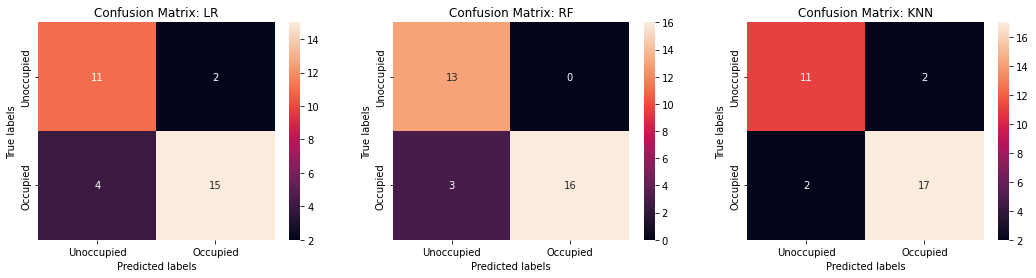

In [143]:
# model names, models and predicted values for each model
models = {'LR':[lr_model, y_pred_lr, y_test, X_test],
        'RF':[rf_model, y_pred_rf, y_test, X_test],
        'KNN':[knn_model, y_pred_knn, y_test, X_test]}

# list of classes
class_names = ['Rock','Mine']

# blank dictionaries for saving evaluation metrics for each model 
accuracy = {}
f1_score_dict = {}
precision = {}
recall = {}

i = 1

%matplotlib inline

plt.figure(figsize=(18,4))

for model, model_output in models.items():
    acc = accuracy_score(model_output[2], model_output[1]) # accuracy
    pre = precision_score(model_output[2], model_output[1]) # precision
    rec = recall_score(model_output[2], model_output[1]) # recall
    f1_sc = f1_score(model_output[2], model_output[1]) # f1 score
    
    # rounding and saving values to disctionary
    accuracy[model] = round(acc,3)
    precision[model] = round(pre,3)
    recall[model] = round(rec,3)
    f1_score_dict[model] = round(f1_sc,3)

    # plotting confusion matrix for each model
    cm = confusion_matrix(model_output[2], model_output[1])

    ax = plt.subplot(1,3,i)
    sns.heatmap(cm, annot=True, ax = ax );

    # labels and titles
    ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
    ax.set_title('Confusion Matrix: '+model);
    ax.xaxis.set_ticklabels(['Unoccupied', 'Occupied']); ax.yaxis.set_ticklabels(['Unoccupied', 'Occupied']);


    print(model)
    print(cm)

    i += 1


plt.show()

In [133]:
df_results = pd.concat([
    pd.Series(accuracy).to_frame('Accuracy'),
    pd.Series(recall).to_frame('Recall'),
    pd.Series(precision).to_frame('Precision'),
    pd.Series(f1_score_dict).to_frame('F1 Score')
], 
    axis=1)

df_results

,Accuracy,Recall,Precision,F1 Score
LR,0.812,0.789,0.882,0.833
RF,0.906,0.842,1.000,0.914
KNN,0.875,0.895,0.895,0.895


Decision

So far, three classification algorithm has been tried. RandomForestClassifier has perfromed the best with an accuracy of 0.906 and F1-Score of 0.914